In [1]:
import os
from os import listdir

names = []

folder_dir = "CAT_00"
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        names.append(images)

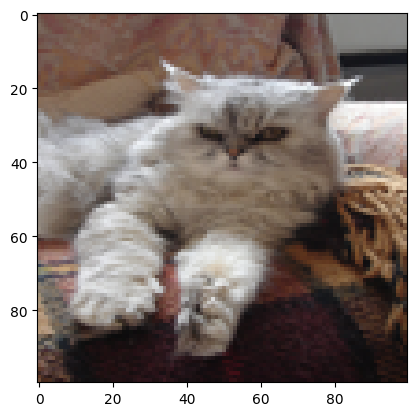

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

names = sorted(names)
img = Image.open(f"CAT_00/{names[0]}")
img = img.resize((100, 100))

imgplot = plt.imshow(img)
plt.show()

In [3]:
len(names)

9993

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianDenoiser(nn.Module):
    def __init__(self):
        super(GaussianDenoiser, self).__init__()
        
        # 1. Time Embedding (Updated to 128 to match bottleneck)
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 128),
            nn.GELU(), # GELU is often better for generative models
            nn.Linear(128, 128)
        )
        
        # Encoder (Downsampling)
        self.enc1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoder (Upsampling)
        # We use ConvTranspose2d to grow the spatial size
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # 128 because of skip connection
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d(64, 32, kernel_size=3, padding=1) # 64 because of skip connection
        
        self.final_conv = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Time processing
        t_emb = self.time_mlp(t)
        t_emb = t_emb.view(t_emb.shape[0], -1, 1, 1)
        
        # Encoder
        h1 = F.gelu(self.enc1(x))    # (32, 100, 100)
        p1 = self.pool(h1)           # (32, 50, 50)
        
        h2 = F.gelu(self.enc2(p1))   # (64, 50, 50)
        p2 = self.pool(h2)           # (64, 25, 25)
        
        h3 = F.gelu(self.enc3(p2))   # (128, 25, 25)
        
        # Bottleneck Injection
        h3 = h3 + t_emb              # Inject time at the deepest level
        
        # Decoder with Skip Connections (Concat)
        x = self.up1(h3)             # (64, 50, 50)
        x = torch.cat([x, h2], dim=1) # Concatenate with enc2 features (64+64=128)
        x = F.gelu(self.dec1(x))
        
        x = self.up2(x)             # (32, 100, 100)
        x = torch.cat([x, h1], dim=1) # Concatenate with enc1 features (32+32=64)
        x = F.gelu(self.dec2(x))
        
        return self.final_conv(x)    # (3, 100, 100)
    
model = GaussianDenoiser()

In [9]:
import torch

def train_step(model, x_1):
    """
    x_1: A batch of real data (images, etc.)
    model: A neural network that predicts velocity v(x, t)
    """
    # 1. Sample random noise (x_0) the same shape as our data
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample a random time step t between 0 and 1
    t = torch.rand(x_1.shape[0], 1, 1, 1) # Match dimensions
    
    # 3. Compute the point on the straight-line path (Probability Path)
    # x_t = (1 - t) * x_0 + t * x_1
    x_t = (1 - t) * x_0 + t * x_1
    
    # 4. The "Ground Truth" velocity is simply the direction of the line
    # target = x_1 - x_0
    target_velocity = x_1 - x_0
    
    # 5. Predict velocity with the model
    predicted_velocity = model(x_t, t)
    
    # 6. Loss is simple Mean Squared Error
    loss = torch.mean((predicted_velocity - target_velocity) ** 2)
    
    return loss

In [10]:
@torch.no_grad()
def sample(model, num_steps=20):
    # Start with pure noise
    x = torch.randn(1, 3, 64, 64)
    dt = 1.0 / num_steps
    
    for i in range(num_steps):
        t = torch.ones(1, 1, 1, 1) * (i / num_steps)
        
        # Get the velocity (direction to move)
        v = model(x, t)
        
        # Move a small step forward: x = x + v * dt
        x = x + v * dt
        
    return x # This is now a generated data point

In [11]:
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for name in names:
    img = Image.open(f"CAT_00/{name}")
    img = img.resize((100, 100))
    img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0  # Normalize to [0, 1]
    
    optimizer.zero_grad()
    loss = train_step(model, img_tensor)
    loss.backward()
    optimizer.step()
    
    print(f"Processed {name}, Loss: {loss.item()}")

Processed 00000001_000.jpg, Loss: 1.218428611755371
Processed 00000001_005.jpg, Loss: 1.2094807624816895
Processed 00000001_008.jpg, Loss: 1.2050011157989502
Processed 00000001_011.jpg, Loss: 1.2367392778396606
Processed 00000001_012.jpg, Loss: 1.0812187194824219
Processed 00000001_016.jpg, Loss: 1.0153874158859253
Processed 00000001_017.jpg, Loss: 1.0400358438491821
Processed 00000001_020.jpg, Loss: 1.0176736116409302
Processed 00000001_024.jpg, Loss: 1.0167194604873657
Processed 00000001_027.jpg, Loss: 0.9967631697654724
Processed 00000001_029.jpg, Loss: 0.9792802929878235
Processed 00000002_001.jpg, Loss: 1.0046544075012207
Processed 00000002_003.jpg, Loss: 0.9754789471626282
Processed 00000002_008.jpg, Loss: 0.986800491809845
Processed 00000002_026.jpg, Loss: 0.928335964679718
Processed 00000003_007.jpg, Loss: 1.0234894752502441
Processed 00000003_009.jpg, Loss: 0.9724555611610413
Processed 00000003_012.jpg, Loss: 0.9722232222557068
Processed 00000003_013.jpg, Loss: 0.9877280592918

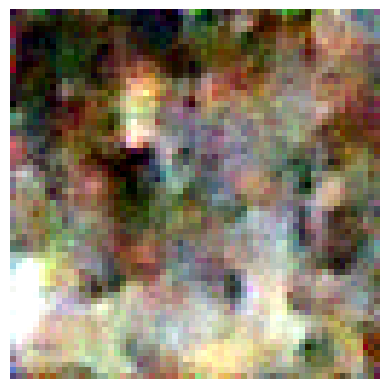

In [ ]:
import matplotlib.pyplot as plt

# 1. Get the output from your sample function
output_tensor = sample(model, num_steps=50) # Shape: [1, 3, 64, 64]

# 2. Remove the batch dimension [3, 64, 64]
img_tensor = output_tensor.squeeze(0)

# # 3. Rescale from [-1, 1] to [0, 1] (if necessary)
img_tensor = (img_tensor + 1) / 2

# 4. Clamp to ensure no values are outside [0, 1]
img_tensor = img_tensor.clamp(0, 1)

# 5. Permute to [64, 64, 3] and convert to CPU/NumPy
img_final = img_tensor.permute(1, 2, 0).cpu().numpy()

# 6. Plot
plt.imshow(img_final)
plt.axis('off')
plt.show()